# NetCDF handling

NetCDF formatted files are much faster to read and write for large datasets. In order to make the most of this, the `ScmRun` objects have the ability to read and write netCDF files.

In [1]:
# NBVAL_IGNORE_OUTPUT
import traceback
from glob import glob

import numpy as np
import seaborn as sns
import xarray as xr

from scmdata.run import ScmRun, run_append
from scmdata.netcdf import nc_to_run

## Helper bits and piecs

In [2]:
OUT_FNAME = "/tmp/out_runs.nc"

In [3]:
def new_timeseries(
    n=100,
    count=1,
    model="example",
    scenario="ssp119",
    variable="Surface Temperature",
    unit="K",
    region="World",
    cls=ScmRun,
    **kwargs,
):
    data = np.random.rand(n, count) * np.arange(n)[:, np.newaxis]
    index = 2000 + np.arange(n)
    return cls(
        data,
        columns={
            "model": model,
            "scenario": scenario,
            "variable": variable,
            "region": region,
            "unit": unit,
            **kwargs,
        },
        index=index,
    )

Let's create an `ScmRun` which contains a few variables and a number of runs. Such a dataframe would be used to store the results from an ensemble of simple climate model runs.

In [4]:
# NBVAL_IGNORE_OUTPUT
runs = run_append(
    [
        new_timeseries(
            count=3,
            variable=[
                "Surface Temperature",
                "Atmospheric Concentrations|CO2",
                "Radiative Forcing",
            ],
            unit=["K", "ppm", "W/m^2"],
            run_id=run_id,
        )
        for run_id in range(10)
    ]
)
runs.metadata["source"] = "fake data"
runs

<ScmRun (timeseries: 30, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	      model region  run_id scenario   unit                        variable
	0   example  World       0   ssp119      K             Surface Temperature
	1   example  World       0   ssp119    ppm  Atmospheric Concentrations|CO2
	2   example  World       0   ssp119  W/m^2               Radiative Forcing
	3   example  World       1   ssp119      K             Surface Temperature
	4   example  World       1   ssp119    ppm  Atmospheric Concentrations|CO2
	5   example  World       1   ssp119  W/m^2               Radiative Forcing
	6   example  World       2   ssp119      K             Surface Temperature
	7   example  World       2   ssp119    ppm  Atmospheric Concentrations|CO2
	8   example  World       2   ssp119  W/m^2               Radiative Forcing
	9   example  World       3   ssp119      K             Surface Temperature
	10  example  World       3   ssp119    ppm  Atmospheri

## Reading/Writing to NetCDF4

### Basics

Writing the runs to disk is easy. The one trick is that each variable and dimension combination must have unique metadata. If they do not, you will receive an error message like the below.

In [5]:
try:
    runs.to_nc(OUT_FNAME, dimensions=["region"])
except ValueError:
    traceback.print_exc(limit=0, chain=False)

Traceback (most recent call last):
ValueError: dimensions: `['region']` and extras: `[]` do not uniquely define the timeseries, please add extra dimensions and/or extras


In our dataset, there is more than one "run_id" per variable hence we need to use a different dimension, `run_id`, because this will result in each variable's remaining metadata being unique.

In [6]:
runs.to_nc(OUT_FNAME, dimensions=["run_id"])

The output netCDF file can be read using the `from_nc` method, `nc_to_run` function or directly using `xarray`.

In [7]:
# NBVAL_IGNORE_OUTPUT
runs_netcdf = ScmRun.from_nc(OUT_FNAME)
runs_netcdf

<ScmRun (timeseries: 30, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	      model region  run_id scenario   unit                        variable
	0   example  World       0   ssp119    ppm  Atmospheric Concentrations|CO2
	1   example  World       0   ssp119  W/m^2               Radiative Forcing
	2   example  World       0   ssp119      K             Surface Temperature
	3   example  World       1   ssp119    ppm  Atmospheric Concentrations|CO2
	4   example  World       1   ssp119  W/m^2               Radiative Forcing
	5   example  World       1   ssp119      K             Surface Temperature
	6   example  World       2   ssp119    ppm  Atmospheric Concentrations|CO2
	7   example  World       2   ssp119  W/m^2               Radiative Forcing
	8   example  World       2   ssp119      K             Surface Temperature
	9   example  World       3   ssp119    ppm  Atmospheric Concentrations|CO2
	10  example  World       3   ssp119  W/m^2            

In [8]:
# NBVAL_IGNORE_OUTPUT
nc_to_run(ScmRun, OUT_FNAME)

<ScmRun (timeseries: 30, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	      model region  run_id scenario   unit                        variable
	0   example  World       0   ssp119    ppm  Atmospheric Concentrations|CO2
	1   example  World       0   ssp119  W/m^2               Radiative Forcing
	2   example  World       0   ssp119      K             Surface Temperature
	3   example  World       1   ssp119    ppm  Atmospheric Concentrations|CO2
	4   example  World       1   ssp119  W/m^2               Radiative Forcing
	5   example  World       1   ssp119      K             Surface Temperature
	6   example  World       2   ssp119    ppm  Atmospheric Concentrations|CO2
	7   example  World       2   ssp119  W/m^2               Radiative Forcing
	8   example  World       2   ssp119      K             Surface Temperature
	9   example  World       3   ssp119    ppm  Atmospheric Concentrations|CO2
	10  example  World       3   ssp119  W/m^2            

In [9]:
# NBVAL_IGNORE_OUTPUT
xr.load_dataset(OUT_FNAME)

<xarray.Dataset>
Dimensions:                          (run_id: 10, time: 100)
Coordinates:
  * time                             (time) datetime64[ns] 2000-01-01 ... 209...
  * run_id                           (run_id) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    Atmospheric_Concentrations__CO2  (run_id, time) float64 0.0 0.3246 ... 43.37
    Radiative_Forcing                (run_id, time) float64 0.0 0.1588 ... 80.55
    Surface_Temperature              (run_id, time) float64 0.0 0.116 ... 69.94
Attributes:
    scmdata_metadata_scenario:  ssp119
    scmdata_metadata_model:     example
    scmdata_metadata_region:    World
    created_at:                 2021-09-13T14:23:52.676524
    _scmdata_version:           0.13.0+7.gf0bcab9.dirty
    source:                     fake data

The additional `metadata` in `runs` is also serialized and deserialized in the netCDF files. The `metadata` of the loaded `ScmRun` will also contain some additional fields about the file creation.

In [10]:
# NBVAL_IGNORE_OUTPUT
assert "source" in runs_netcdf.metadata
runs_netcdf.metadata

{'created_at': '2021-09-13T14:23:52.676524',
 '_scmdata_version': '0.13.0+7.gf0bcab9.dirty',
 'source': 'fake data'}

### Splitting your data

Sometimes if you have complicated ensemble runs it might be more efficient to split the data into smaller subsets.

In the below example we iterate over scenarios to produce a netCDF file per scenario.

In [11]:
large_run = []

# 10 runs for each scenario
for sce in ["ssp119", "ssp370", "ssp585"]:
    large_run.extend(
        [
            new_timeseries(
                count=3,
                scenario=sce,
                variable=[
                    "Surface Temperature",
                    "Atmospheric Concentrations|CO2",
                    "Radiative Forcing",
                ],
                unit=["K", "ppm", "W/m^2"],
                paraset_id=paraset_id,
            )
            for paraset_id in range(10)
        ]
    )

large_run = run_append(large_run)

# also set a run_id (often we'd have paraset_id and run_id,
# one which keeps track of the parameter set we've run and
# the other which keeps track of the run in a large ensemble)
large_run["run_id"] = large_run.meta.index.values
large_run

<ScmRun (timeseries: 90, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	      model  paraset_id region  run_id scenario   unit                        variable
	0   example           0  World       0   ssp119      K             Surface Temperature
	1   example           0  World       1   ssp119    ppm  Atmospheric Concentrations|CO2
	2   example           0  World       2   ssp119  W/m^2               Radiative Forcing
	3   example           1  World       3   ssp119      K             Surface Temperature
	4   example           1  World       4   ssp119    ppm  Atmospheric Concentrations|CO2
	5   example           1  World       5   ssp119  W/m^2               Radiative Forcing
	6   example           2  World       6   ssp119      K             Surface Temperature
	7   example           2  World       7   ssp119    ppm  Atmospheric Concentrations|CO2
	8   example           2  World       8   ssp119  W/m^2               Radiative Forcing
	9   exampl

Data for each scenario can then be loaded independently instead of having to load all the data and then filtering

In [12]:
for sce_run in large_run.groupby("scenario"):
    sce = sce_run.get_unique_meta("scenario", True)
    sce_run.to_nc(
        "/tmp/out-{}-sparse.nc".format(sce),
        dimensions=["run_id", "paraset_id"],
    )

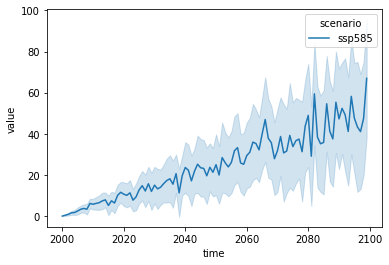

In [13]:
# NBVAL_IGNORE_OUTPUT
ScmRun.from_nc("/tmp/out-ssp585-sparse.nc").filter(
    "Surface Temperature"
).line_plot()

For such a data set, since both `run_id` and `paraset_id` vary, both could be added as dimensions in the file.

The one problem with this approach is that you get very sparse arrays because the data is written on a 100 x 30 x 90 (time points x paraset_id x run_id) grid but there's only 90 timeseries so you end up with 180 timeseries worth of nans (although this is a relatively small problem because the netCDF files use compression to minismise the impact of the extra nan values).

In [14]:
# NBVAL_IGNORE_OUTPUT
xr.load_dataset("/tmp/out-ssp585-sparse.nc")

<xarray.Dataset>
Dimensions:                          (paraset_id: 10, run_id: 30, time: 100)
Coordinates:
  * time                             (time) datetime64[ns] 2000-01-01 ... 209...
  * run_id                           (run_id) int64 60 61 62 63 ... 86 87 88 89
  * paraset_id                       (paraset_id) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    Atmospheric_Concentrations__CO2  (run_id, paraset_id, time) float64 nan ....
    Radiative_Forcing                (run_id, paraset_id, time) float64 nan ....
    Surface_Temperature              (run_id, paraset_id, time) float64 0.0 ....
Attributes:
    scmdata_metadata_scenario:  ssp585
    scmdata_metadata_model:     example
    scmdata_metadata_region:    World
    created_at:                 2021-09-13T14:23:53.155089
    _scmdata_version:           0.13.0+7.gf0bcab9.dirty

In [15]:
# NBVAL_IGNORE_OUTPUT
# Load all scenarios
run_append(
    [ScmRun.from_nc(fname) for fname in glob("/tmp/out-ssp*-sparse.nc")]
)

<ScmRun (timeseries: 90, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	      model  paraset_id region  run_id scenario   unit                        variable
	0   example           0  World      30   ssp370      K             Surface Temperature
	1   example           0  World      31   ssp370    ppm  Atmospheric Concentrations|CO2
	2   example           0  World      32   ssp370  W/m^2               Radiative Forcing
	3   example           1  World      33   ssp370      K             Surface Temperature
	4   example           1  World      34   ssp370    ppm  Atmospheric Concentrations|CO2
	5   example           1  World      35   ssp370  W/m^2               Radiative Forcing
	6   example           2  World      36   ssp370      K             Surface Temperature
	7   example           2  World      37   ssp370    ppm  Atmospheric Concentrations|CO2
	8   example           2  World      38   ssp370  W/m^2               Radiative Forcing
	9   exampl

An alternative to the sparse arrays is to specify the variables in the `extras` attribute. If possible, this adds the metadata to the netCDF file as an extra co-ordinate, which uses one of the dimensions as it's co-ordinate. If using one of the dimensions as a co-ordinate would not specify the metadata uniquely, we add the extra as an additional co-ordinate, which itself has co-ordinates of `_id`. This `_id` co-ordinate provides a unique mapping between the extra metadata and the timeseries.

In [16]:
for sce_run in large_run.groupby("scenario"):
    sce = sce_run.get_unique_meta("scenario", True)
    sce_run.to_nc(
        "/tmp/out-{}-extras.nc".format(sce),
        dimensions=["run_id"],
        extras=["paraset_id"],
    )

`paraset_id` is uniquely defined by `run_id` so we don't end up with an extra `_id` co-ordinate.

In [17]:
# NBVAL_IGNORE_OUTPUT
xr.load_dataset("/tmp/out-ssp585-extras.nc")

<xarray.Dataset>
Dimensions:                          (run_id: 30, time: 100)
Coordinates:
  * time                             (time) datetime64[ns] 2000-01-01 ... 209...
  * run_id                           (run_id) int64 60 61 62 63 ... 86 87 88 89
    paraset_id                       (run_id) int64 0 0 0 1 1 1 ... 8 8 8 9 9 9
Data variables:
    Atmospheric_Concentrations__CO2  (run_id, time) float64 nan nan ... nan nan
    Radiative_Forcing                (run_id, time) float64 nan nan ... 73.3
    Surface_Temperature              (run_id, time) float64 0.0 0.6868 ... nan
Attributes:
    scmdata_metadata_scenario:  ssp585
    scmdata_metadata_model:     example
    scmdata_metadata_region:    World
    created_at:                 2021-09-13T14:23:53.486575
    _scmdata_version:           0.13.0+7.gf0bcab9.dirty

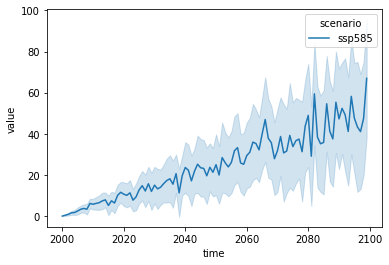

In [18]:
# NBVAL_IGNORE_OUTPUT
ScmRun.from_nc("/tmp/out-ssp585-extras.nc").filter(
    "Surface Temperature"
).line_plot()

If we use dimensions and extra such that our extra co-ordinates are not uniquely defined by the regions, an `_id` dimension is automatically added to ensure we don't lose any information.

In [19]:
large_run.to_nc(
    "/tmp/out-extras-sparse.nc",
    dimensions=["scenario"],
    extras=["paraset_id", "run_id"],
)

In [20]:
# NBVAL_IGNORE_OUTPUT
xr.load_dataset("/tmp/out-extras-sparse.nc")

<xarray.Dataset>
Dimensions:                          (_id: 90, scenario: 3, time: 100)
Coordinates:
  * time                             (time) datetime64[ns] 2000-01-01 ... 209...
  * scenario                         (scenario) object 'ssp119' ... 'ssp585'
  * _id                              (_id) int64 0 1 2 3 4 5 ... 85 86 87 88 89
    paraset_id                       (_id) int64 0 0 0 1 1 1 2 ... 7 8 8 8 9 9 9
    run_id                           (_id) int64 0 1 2 3 4 5 ... 85 86 87 88 89
Data variables:
    Atmospheric_Concentrations__CO2  (scenario, time, _id) float64 nan ... nan
    Radiative_Forcing                (scenario, time, _id) float64 nan ... 73.3
    Surface_Temperature              (scenario, time, _id) float64 0.0 ... nan
Attributes:
    scmdata_metadata_model:   example
    scmdata_metadata_region:  World
    created_at:               2021-09-13T14:23:53.769248
    _scmdata_version:         0.13.0+7.gf0bcab9.dirty

### Multi-dimensional data

**scmdata** can also handle having more than one dimension. This can be especially helpful if you have output from a number of models (IAMs), scenarios, regions and runs.

In [21]:
multi_dimensional_run = []

for model in ["AIM", "GCAM", "MESSAGE", "REMIND"]:
    for sce in ["ssp119", "ssp370", "ssp585"]:
        for region in ["World", "R5LAM", "R5MAF", "R5ASIA", "R5OECD", "R5REF"]:
            multi_dimensional_run.extend(
                [
                    new_timeseries(
                        count=3,
                        model=model,
                        scenario=sce,
                        region=region,
                        variable=[
                            "Surface Temperature",
                            "Atmospheric Concentrations|CO2",
                            "Radiative Forcing",
                        ],
                        unit=["K", "ppm", "W/m^2"],
                        paraset_id=paraset_id,
                    )
                    for paraset_id in range(10)
                ]
            )

multi_dimensional_run = run_append(multi_dimensional_run)

multi_dimensional_run

<ScmRun (timeseries: 2160, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	       model  paraset_id region scenario   unit                        variable
	0        AIM           0  World   ssp119      K             Surface Temperature
	1        AIM           0  World   ssp119    ppm  Atmospheric Concentrations|CO2
	2        AIM           0  World   ssp119  W/m^2               Radiative Forcing
	3        AIM           1  World   ssp119      K             Surface Temperature
	4        AIM           1  World   ssp119    ppm  Atmospheric Concentrations|CO2
	5        AIM           1  World   ssp119  W/m^2               Radiative Forcing
	6        AIM           2  World   ssp119      K             Surface Temperature
	7        AIM           2  World   ssp119    ppm  Atmospheric Concentrations|CO2
	8        AIM           2  World   ssp119  W/m^2               Radiative Forcing
	9        AIM           3  World   ssp119      K             Surface Temperatur

In [22]:
multi_dim_outfile = "/tmp/out-multi-dimensional.nc"

In [23]:
multi_dimensional_run.to_nc(
    multi_dim_outfile,
    dimensions=("region", "model", "scenario", "paraset_id"),
)

In [24]:
# NBVAL_IGNORE_OUTPUT
xr.load_dataset(multi_dim_outfile)

<xarray.Dataset>
Dimensions:                          (model: 4, paraset_id: 10, region: 6, scenario: 3, time: 100)
Coordinates:
  * time                             (time) datetime64[ns] 2000-01-01 ... 209...
  * scenario                         (scenario) object 'ssp119' ... 'ssp585'
  * model                            (model) object 'AIM' 'GCAM' ... 'REMIND'
  * region                           (region) object 'R5ASIA' ... 'World'
  * paraset_id                       (paraset_id) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    Atmospheric_Concentrations__CO2  (region, model, scenario, paraset_id, time) float64 ...
    Radiative_Forcing                (region, model, scenario, paraset_id, time) float64 ...
    Surface_Temperature              (region, model, scenario, paraset_id, time) float64 ...
Attributes:
    created_at:        2021-09-13T14:23:57.575682
    _scmdata_version:  0.13.0+7.gf0bcab9.dirty

In [25]:
# NBVAL_IGNORE_OUTPUT
multi_dim_loaded_co2_conc = ScmRun.from_nc(multi_dim_outfile).filter(
    "Atmospheric Concentrations|CO2"
)

seaborn_df = multi_dim_loaded_co2_conc.long_data()
seaborn_df.head()

,model,paraset_id,region,scenario,unit,variable,time,value
0,AIM,0,R5ASIA,ssp119,ppm,Atmospheric Concentrations|CO2,2000-01-01,0.000000
1,AIM,0,R5ASIA,ssp119,ppm,Atmospheric Concentrations|CO2,2001-01-01,0.804389
2,AIM,0,R5ASIA,ssp119,ppm,Atmospheric Concentrations|CO2,2002-01-01,0.045223
3,AIM,0,R5ASIA,ssp119,ppm,Atmospheric Concentrations|CO2,2003-01-01,0.376122
4,AIM,0,R5ASIA,ssp119,ppm,Atmospheric Concentrations|CO2,2004-01-01,1.162506


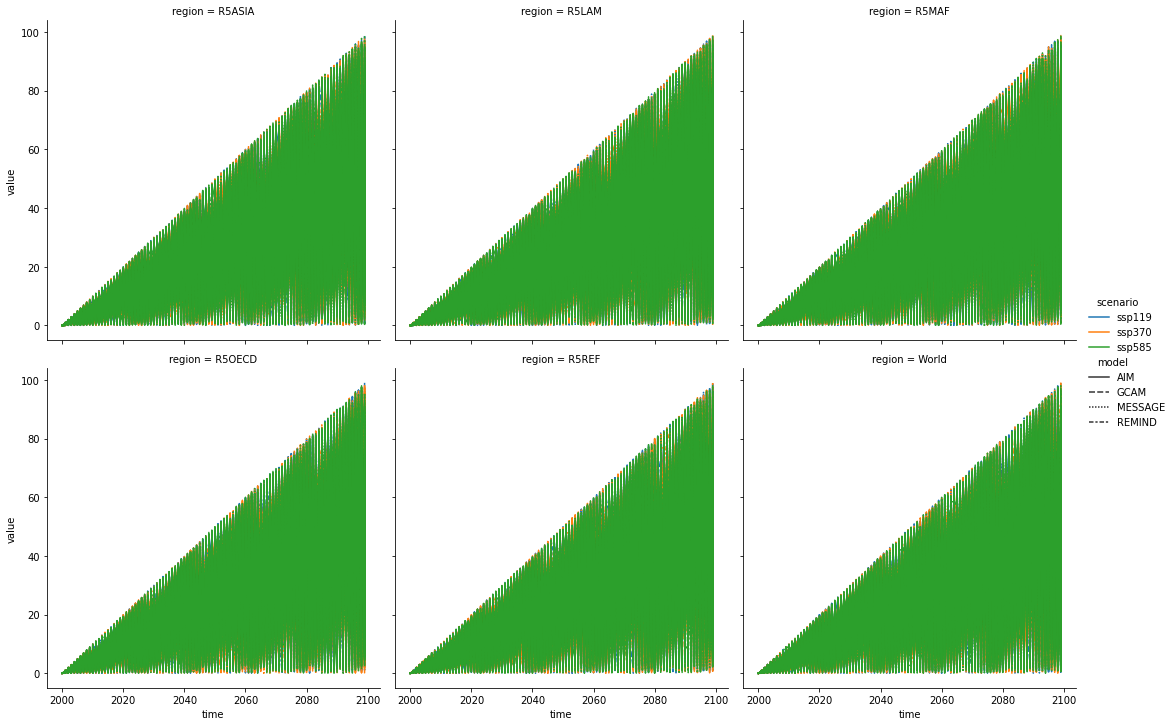

In [26]:
# NBVAL_IGNORE_OUTPUT
sns.relplot(
    data=seaborn_df,
    x="time",
    y="value",
    units="paraset_id",
    estimator=None,
    hue="scenario",
    style="model",
    col="region",
    col_wrap=3,
    kind="line",
)